In [1]:
import os 
import sys
sys.path.append("/home/nshokran/projects/utilities")
#import matrix_factorization_methods
import utils
import math
import pandas as pd
import numpy as np
import seaborn as sns
from stellargraph import StellarGraph
from stellargraph.data import UniformRandomWalk
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples as si

2021-11-21 11:10:40.996014: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-21 11:10:41.021013: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-21 11:10:41.032676: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
def balance(mat):
    mat_size = mat.shape[0]
    B = np.ones(mat_size)
    row_sums = np.sum(mat,axis=0)
    row_sums = row_sums / np.mean(row_sums)
    th = 1E-6
    while np.var(row_sums) > th:
        row_sums = np.sum(mat,axis=0)
        row_sums = row_sums / np.mean(row_sums)
        norm_mat = np.outer(row_sums,row_sums)
        mat = mat/norm_mat
        B = B*row_sums
    return B,mat
def write_embeddings(df,dim,out_folder):
    if not os.path.exists(out_folder):
        os.mkdir(out_folder)
    for d in np.arange(1,dim+1):
        curr_df = df.loc[:,['chr_name','pos','emb'+str(d)]]
        curr_df['end'] = curr_df['pos']+1
        curr_df = curr_df.loc[:,['chr_name','pos','end','emb'+str(d)]]
        curr_df.to_csv(os.path.join(out_folder,"emb"+str(d)+".txt"), header = None, index = False, sep = "\t")
cell_type = "GM12878"
resolution = 100000
chr_num = 21

In [ ]:
assays_df = utils.create_assays_df(cell_type,resolution)
SC_annot_path = "/home/nshokran/projects/Hi-C-GenomicAssays-Chromatin-State-Annotation/data/annotations/Rao_SC.bed"
SC_annotation = utils.melt_annotation(utils.read_annot_file(SC_annot_path,1,100000))

In [5]:
contact_mat = utils.create_hic_mat(cell_type,chr_num,chr_num,resolution,'oe')
valid_indices = np.where(np.sum(contact_mat,axis=0)!=0)[0]
contact_mat = contact_mat[np.ix_(valid_indices,valid_indices)]
#contact_mat[np.where(contact_mat == 0)] = np.nan

In [17]:
corr_mat_self_loop = np.corrcoef(contact_mat) + 2
corr_mat = corr_mat_self_loop - np.diag(np.diag(corr_mat_self_loop))
_,balanced_contact_mat = balance(contact_mat)

In [27]:
def NMF_emb(mat,chr_name,valid_indices,dim):
    NMF_model = NMF(n_components=dim, init='random', random_state=0)
    NMF_model = NMF_model.fit(mat)
    NMF_embedding = NMF_model.transform(mat)
    NMF_reconstruction = NMF_model.inverse_transform(NMF_embedding)
    tsne = TSNE(n_components=2, random_state=42)
    weighted_node_embeddings_2d = tsne.fit_transform(NMF_embedding)
    NMF_embedding = pd.DataFrame(NMF_embedding)
    NMF_embedding.columns = ["emb" + str(i) for i in np.arange(1,dim+1)]
    NMF_embedding[['tsne1','tsne2']] = weighted_node_embeddings_2d
    NMF_embedding['chr_name'] = chr_name
    NMF_embedding['pos'] = valid_indices
    return NMF_embedding, NMF_reconstruction

In [52]:
NMF_embeddings = {}
for dim in [4,8,12]:
    NMF_embeddings[dim], _ = NMF_emb(contact_mat,"chr21",valid_indices,dim)
    NMF_embeddings[dim] = pd.merge(NMF_embeddings[dim],SC_annotation,on=['chr_name','pos'])
    #NMF_embedding = pd.merge(NMF_embedding,assays_df,on=['chr_name','pos'])

/home/nshokran/miniconda3/envs/embedding/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/nshokran/miniconda3/envs/embedding/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)
/home/nshokran/miniconda3/envs/embedding/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1091: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


In [43]:
write_embeddings(NMF_embedding,5,"temp/")

<AxesSubplot:>

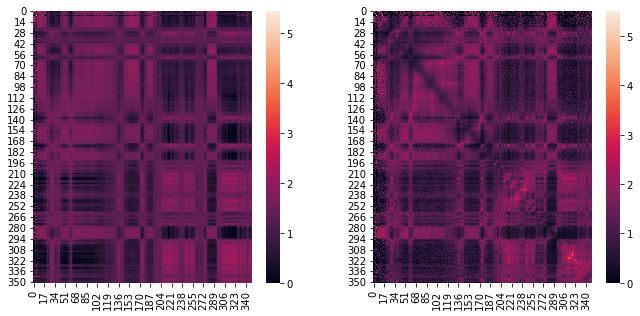

In [46]:
fig = plt.figure(figsize=(11,5))
ax1 = plt.subplot2grid((5,11), (0,0), colspan=5, rowspan=5)
ax2 = plt.subplot2grid((5,11), (0,6), colspan=5, rowspan=5)
sns.heatmap(np.arcsinh(NMF_reconstruction), ax = ax1)
sns.heatmap(np.arcsinh(balanced_contact_mat), ax = ax2)

<AxesSubplot:>

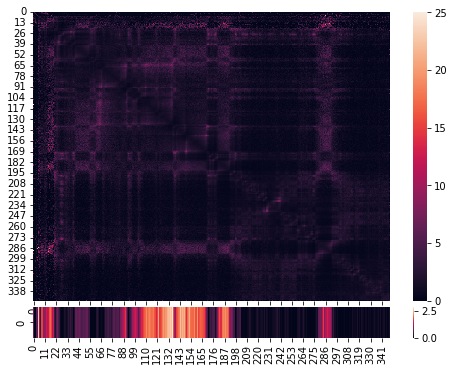

In [23]:
fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((9,8), (0,0), colspan=8, rowspan=8)
ax2 = plt.subplot2grid((9,8), (8,0), colspan=8, rowspan=1)
sns.heatmap(contact_mat,ax = ax1)
sns.heatmap(np.array(NMF_embedding['emb1']).reshape(1,-1),ax=ax2)

In [56]:
contact_list, indices = utils.create_hic_list(cell_type,chr_num,chr_num,resolution,'oe')
contact_graph = StellarGraph(edges=contact_list)

In [65]:
def generate_w2v_embedding(contact_graph,biased,length,num,p,q,dim,window):
    if biased:
        rw = BiasedRandomWalk(contact_graph)
        weighted_walks = rw.run(
        nodes=contact_graph.nodes(),  # root nodes
        length=length,  # maximum length of a random walk
        n=num,  # number of random walks per root node
        p=p,  # Defines (unormalised) probability, 1/p, of returning to source node
        q=q,  # Defines (unormalised) probability, 1/q, for moving away from source node
        weighted=True,  # for weighted random walks
        seed=42,  # random seed fixed for reproducibility
        )
    else:
        rw = UniformRandomWalk(contact_graph)
        weighted_walks = rw.run(
        nodes=contact_graph.nodes(),  # root nodes
        length=length,  # maximum length of a random walk
        n=num,  # number of random walks per root node
        seed=42,  # random seed fixed for reproducibility
        )
    weighted_model = Word2Vec(
    weighted_walks, size=dim, window=window, min_count=0, sg=1, workers=1, iter=1)
    emb_df = []
    for node_id in contact_graph.nodes():
        emb_row = {'id': node_id}
        for i,emb in enumerate(weighted_model.wv[node_id]):
            emb_row['emb'+str(i+1)] = emb
        emb_df.append(emb_row)
    emb_df = pd.DataFrame(emb_df)
    tsne = TSNE(n_components=2, random_state=42)
    weighted_node_embeddings_2d = tsne.fit_transform(emb_df.iloc[:,1:])
    emb_df[['tsne1','tsne2']] = weighted_node_embeddings_2d
    emb_df = pd.merge(emb_df,indices,on="id")
    return (emb_df)

In [91]:
DW_embeddings = {}
n2v_embeddings = {}
for dim in [12]:
    for l in [2,4,6]:
        DW_embeddings[dim,l] = generate_w2v_embedding(contact_graph,0,l,100,0.5,2,dim,int(l/2))
        n2v_embeddings[dim,l] = generate_w2v_embedding(contact_graph,1,l,100,0.5,2,dim,int(l/2))
        DW_embeddings[dim,l] = pd.merge(DW_embeddings[dim,l],SC_annotation,on=['chr_name','pos'])
        n2v_embeddings[dim,l] = pd.merge(n2v_embeddings[dim,l],SC_annotation,on=['chr_name','pos'])

<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

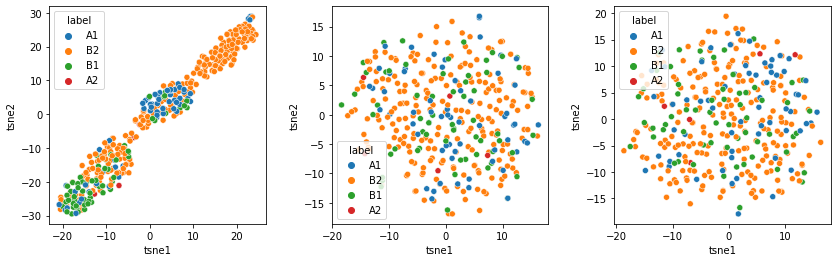

In [92]:
fig = plt.figure(figsize=(14,4))
ax1 = plt.subplot2grid((3,14), (0,0), colspan=4, rowspan=3)
ax2 = plt.subplot2grid((3,14), (0,5), colspan=4, rowspan=3)
ax3 = plt.subplot2grid((3,14), (0,10), colspan=4, rowspan=3)
sns.scatterplot(data = DW_embeddings[12,2], x = 'tsne1', y = 'tsne2', hue = 'label', ax = ax1)
sns.scatterplot(data = DW_embeddings[12,4], x = 'tsne1', y = 'tsne2', hue = 'label', ax = ax2)
sns.scatterplot(data = DW_embeddings[12,6], x = 'tsne1', y = 'tsne2', hue = 'label', ax = ax3)

<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

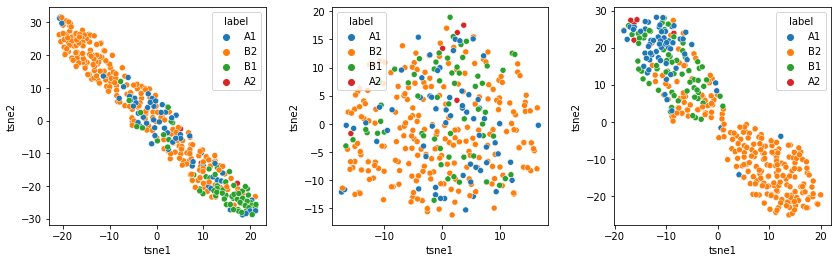

In [93]:
fig = plt.figure(figsize=(14,4))
ax1 = plt.subplot2grid((3,14), (0,0), colspan=4, rowspan=3)
ax2 = plt.subplot2grid((3,14), (0,5), colspan=4, rowspan=3)
ax3 = plt.subplot2grid((3,14), (0,10), colspan=4, rowspan=3)
sns.scatterplot(data = n2v_embeddings[12,2], x = 'tsne1', y = 'tsne2', hue = 'label', ax = ax1)
sns.scatterplot(data = n2v_embeddings[12,4], x = 'tsne1', y = 'tsne2', hue = 'label', ax = ax2)
sns.scatterplot(data = n2v_embeddings[12,6], x = 'tsne1', y = 'tsne2', hue = 'label', ax = ax3)